# Momentum Strategy

In [34]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
# use glob to get all the csv files 
# in the folder
path = r'C:\Users\james\OneDrive\Documents\GitHub\jamsydLibrary\approved_projects\interactive_brokers\Data\spy_tickers'
csv_files = glob.glob(os.path.join(path, "*.csv"))

In [36]:
settings = [18,50,200]

position_dict = {'position_id':[],
                 'return':[],
                 'std':[],
                 'days_in_trade':[],
                 'ema1':[],
                 'ema2':[],
                 'ema3':[],
                 }

In [37]:
def triple_ma(file, settings):

    position_dict = {'position_id':[],
                 'return':[],
                 'std':[],
                 'days_in_trade':[],
                 'ema1':[],
                 'ema2':[],
                 'ema3':[],
                 }

    time_series = pd.read_csv(file, parse_dates=True, index_col='Date')

    # Calculate the EWMA with a span of 20
    time_series['ema']  = time_series['Close'].ewm(span=settings[0], adjust=False).mean()
    time_series['ema1'] = time_series['Close'].ewm(span=settings[1], adjust=False).mean()
    time_series['ema2'] = time_series['Close'].ewm(span=settings[2], adjust=False).mean()

    # Create our PnL vector
    time_series['pnl'] = time_series['Close'].diff(1)

    ath_vector = []

    i = 0
    while i < len(time_series):
        ath_vector.append(time_series['Close'].iloc[0:i].max())
        i+=1

    time_series['ath'] = ath_vector
    time_series['ath_drawdown'] = time_series['Close']/time_series['ath']

    time_series['position'] = np.where((time_series['ema'] > time_series['ema1']) & 
                                       (time_series['ema1'] > time_series['ema2']) & 
                                       (time_series['ath_drawdown'] > 0.95), 1, 
                                    np.where((time_series['ema'] < time_series['ema1']) & 
                                            (time_series['ema1'] < time_series['ema2']) & 
                                            (time_series['ath_drawdown'] < 0.7) & 
                                            (time_series['ath_drawdown'] > 0.3), -1, 0))

    # Create a position identifier
    i               = 0
    vector          = []
    position_size   = []
    entry_price     = []
    initial_capital = 100000
    while i < len(time_series):

        if time_series['position'][i] == 0:
            vector.append(0)
            position_size.append(0)
            entry_price.append(0)

            i += 1  # Move to the next index
        else:
            # Start j = 0 so that we only account for pnl once position is taken
            j = 1
            vector.append(0)
            position_size.append(0)
            entry_price.append(time_series['Close'][i])
            position_identifier = f"{file}_{i}"
            while i + j < len(time_series) and time_series['position'][i + j] == 1:
                if j == 1:
                    size = np.floor(initial_capital/time_series['Close'][i])
                entry_price.append(time_series['Close'][i])
                vector.append(position_identifier)
                position_size.append(size)
                j += 1

            i = j + i

    time_series['vector']        = vector
    time_series['position_size'] = position_size
    time_series['entry_price']   = entry_price

    # Create PnL Vector
    time_series['pnl_vector'] = time_series['pnl']*time_series['position']*time_series['position_size']

    trade_summary = time_series.copy()

    for position_id in trade_summary['vector'].unique()[1:]:
        position_dict['position_id'].append(position_id)
        position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
        position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
        position_dict['days_in_trade'].append(len(trade_summary[trade_summary['vector'] == position_id]))
        position_dict['ema1'].append(settings[0])
        position_dict['ema2'].append(settings[1])
        position_dict['ema3'].append(settings[2])
    
    return time_series, position_dict


In [38]:
m = 0
historical_data = []
for file in csv_files:

    time_series = pd.read_csv(file,parse_dates=True,index_col='Date')

    # Calculate the EWMA with a span of 20
    time_series['ema']  = time_series['Close'].ewm(span=settings[0], adjust=False).mean()
    time_series['ema1'] = time_series['Close'].ewm(span=settings[1], adjust=False).mean()
    time_series['ema2'] = time_series['Close'].ewm(span=settings[2], adjust=False).mean()

    # Create our PnL vector
    time_series['pnl'] = time_series['Close'].diff(1)

    ath_vector = []

    i = 0
    while i < len(time_series):
        ath_vector.append(time_series['Close'].iloc[0:i].min())
        i+=1

    time_series['ath'] = ath_vector
    time_series['ath_drawdown'] = time_series['Close']/time_series['ath']

    time_series['position'] = np.where((time_series['ema'] < time_series['ema1']) & 
                                    (time_series['ema1'] < time_series['ema2']) & (time_series['ath_drawdown'] < 1.05), 1,0) 
                                    # np.where((time_series['ema'] < time_series['ema1']) & 
                                    #         (time_series['ema1'] < time_series['ema2']) & (time_series['ath_drawdown'] < 0.7) & (time_series['ath_drawdown'] > 0.3), -1, 0))

    # Create a position identifier
    i               = 0
    vector          = []
    position_size   = []
    entry_price     = []
    initial_capital = 100000
    while i < len(time_series):

        if time_series['position'][i] == 0:
            vector.append(0)
            position_size.append(0)
            entry_price.append(0)

            i += 1  # Move to the next index
        else:
            # Start j = 0 so that we only account for pnl once position is taken
            j = 1
            vector.append(0)
            position_size.append(0)
            entry_price.append(time_series['Close'][i])
            position_identifier = f"{file}_{i}"
            while i + j < len(time_series) and time_series['position'][i + j] == 1:
                if j == 1:
                    size = np.floor(initial_capital/time_series['Close'][i])
                entry_price.append(time_series['Close'][i])
                vector.append(position_identifier)
                position_size.append(size)
                j += 1

            i = j + i

    time_series['vector']        = vector
    time_series['position_size'] = position_size
    time_series['entry_price']   = entry_price

    # Create PnL Vector
    time_series['pnl_vector'] = time_series['pnl']*time_series['position']*time_series['position_size']

    trade_summary = time_series.copy()


    for position_id in trade_summary['vector'].unique()[1:]:
        position_dict['position_id'].append(position_id)
        position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
        position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
        position_dict['days_in_trade'].append(len(trade_summary[trade_summary['vector'] == position_id]))
        position_dict['ema1'].append(settings[0])
        position_dict['ema2'].append(settings[1])
        position_dict['ema3'].append(settings[2])

    historical_data.append(trade_summary)

    m+=1
    print(m)

    if m > 100:
        break

        

C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

1


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

2


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

3
4


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

5


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:


6


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

7


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

8


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:


9


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:


10


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

11


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

12


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

13


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

14


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

15


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

16


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

17


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

18


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

19


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

20


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

21


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

22


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

23


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

24


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

25


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

26


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

27


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

28


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))


29


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

30


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

31


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

32


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

33


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

34


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

35


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

36


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

37


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

38


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

39


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

40


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

41


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

42


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

43


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

44


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

45


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:


46


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

47


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))


48


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

49


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

50


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

51


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

52


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

53


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

54


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

55


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

56


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

57


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

58


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

59


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

60


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

61


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

62
63


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

64


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

65
66


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < len(time_series) and time_series['position'][i + j] == 1:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

67


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

68


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

69


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))


70


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

71


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

72


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

73


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

74


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

75


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

76


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

77


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

78


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

79


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

80


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

81


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

82


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

83


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

84


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

85


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

86


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

87


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

88


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

89


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

90


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

91


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

92


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:


93


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

94


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:


95


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:


96
97


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

98


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

99


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

100


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['Close'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while i + j < 

101


C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_18208\1609251918.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))


In [66]:
position_dict.keys()

dict_keys(['position_id', 'return', 'std', 'days_in_trade', 'ema1', 'ema2', 'ema3'])

In [67]:
for key in position_dict.keys():
    print(len(position_dict[key]))

806
806
806
806
806
806
806


In [68]:
position_df = pd.DataFrame(position_dict)

position_df['return_per_day'] = position_df['return']/position_df['days_in_trade']
position_df['standardized_return_per_day'] = position_df['return']/position_df['std']/position_df['days_in_trade']

### Return per day

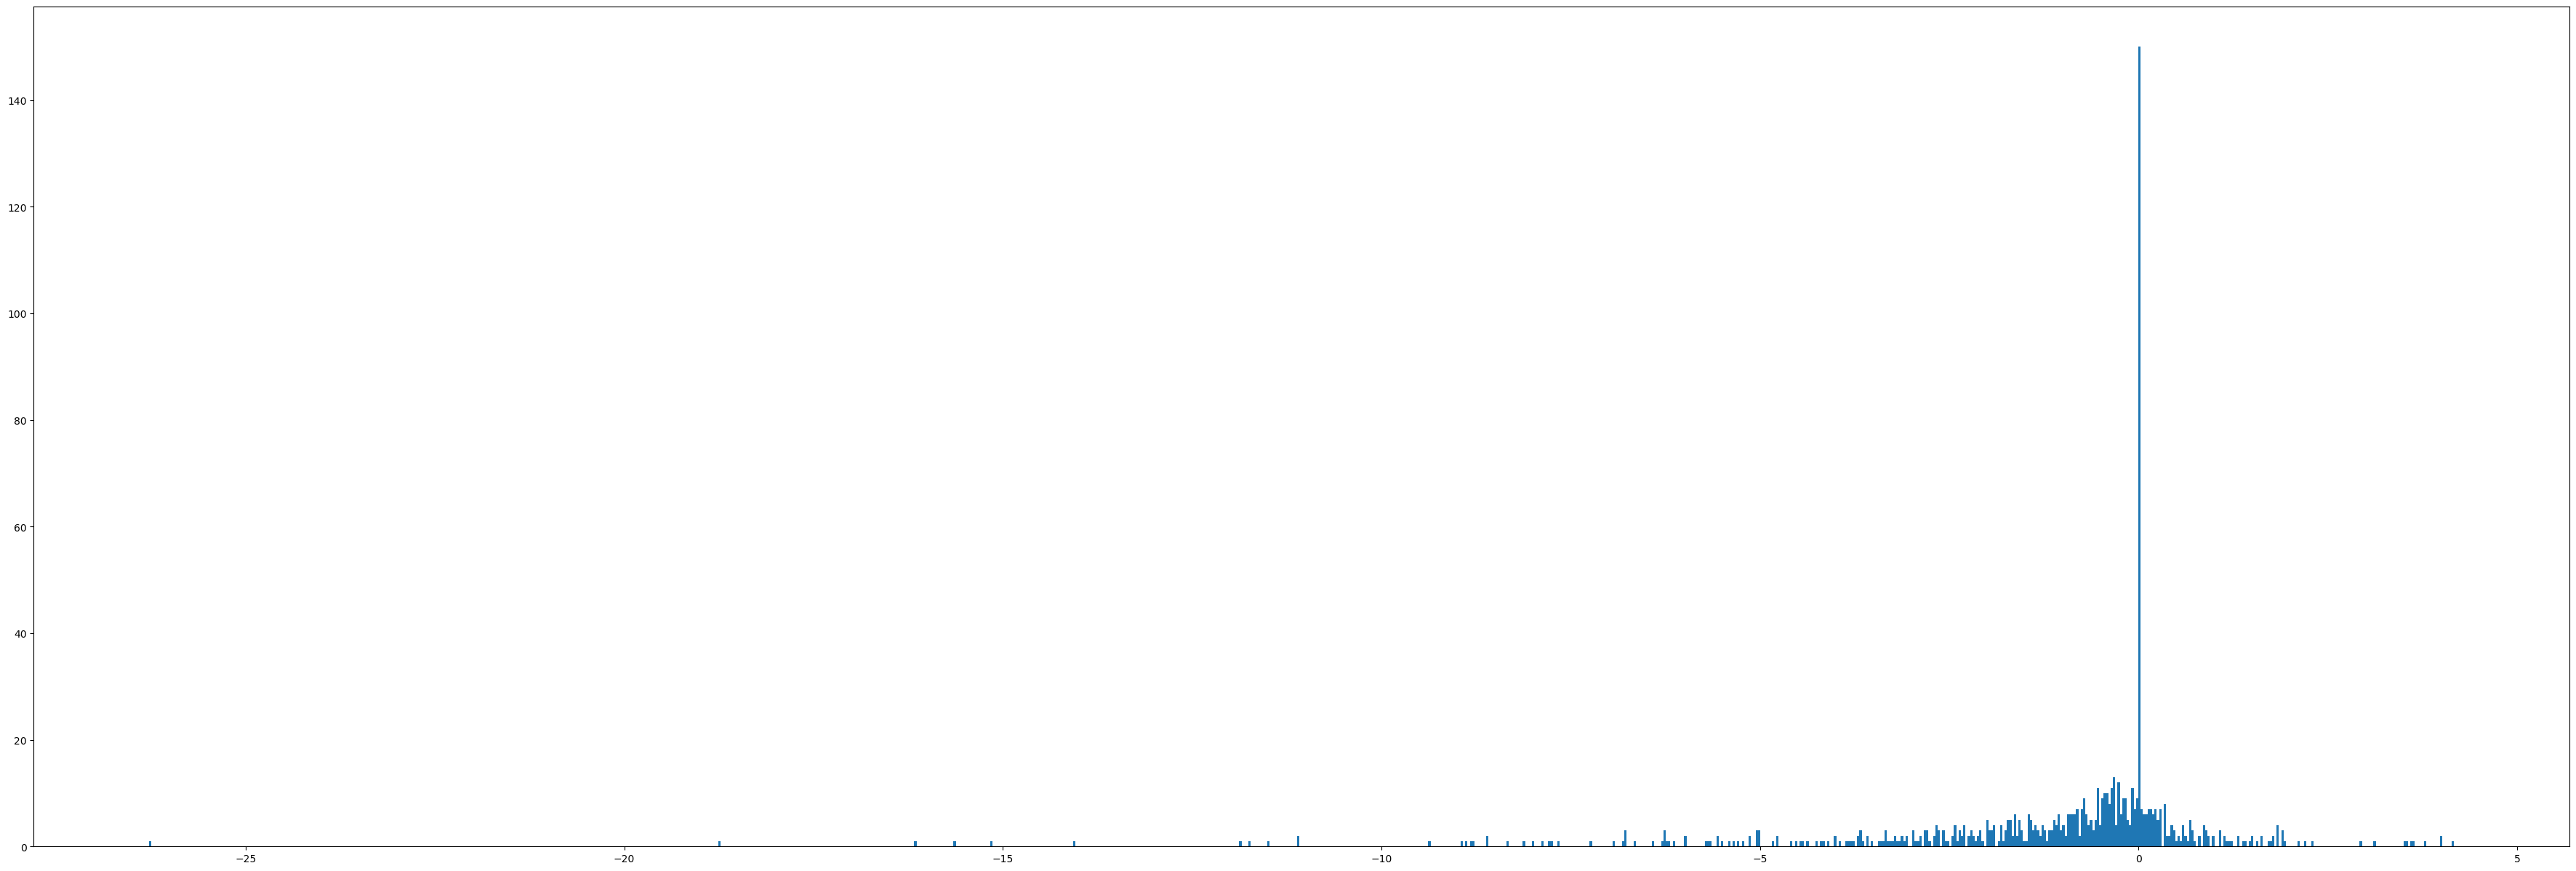

In [69]:
plt.figure(figsize=(45,15))
plt.hist(position_df[(position_df['return_per_day'] != np.inf) & (position_df['return_per_day'] != -np.inf)]['return_per_day'],bins=1000)
plt.show()

### Return per trade

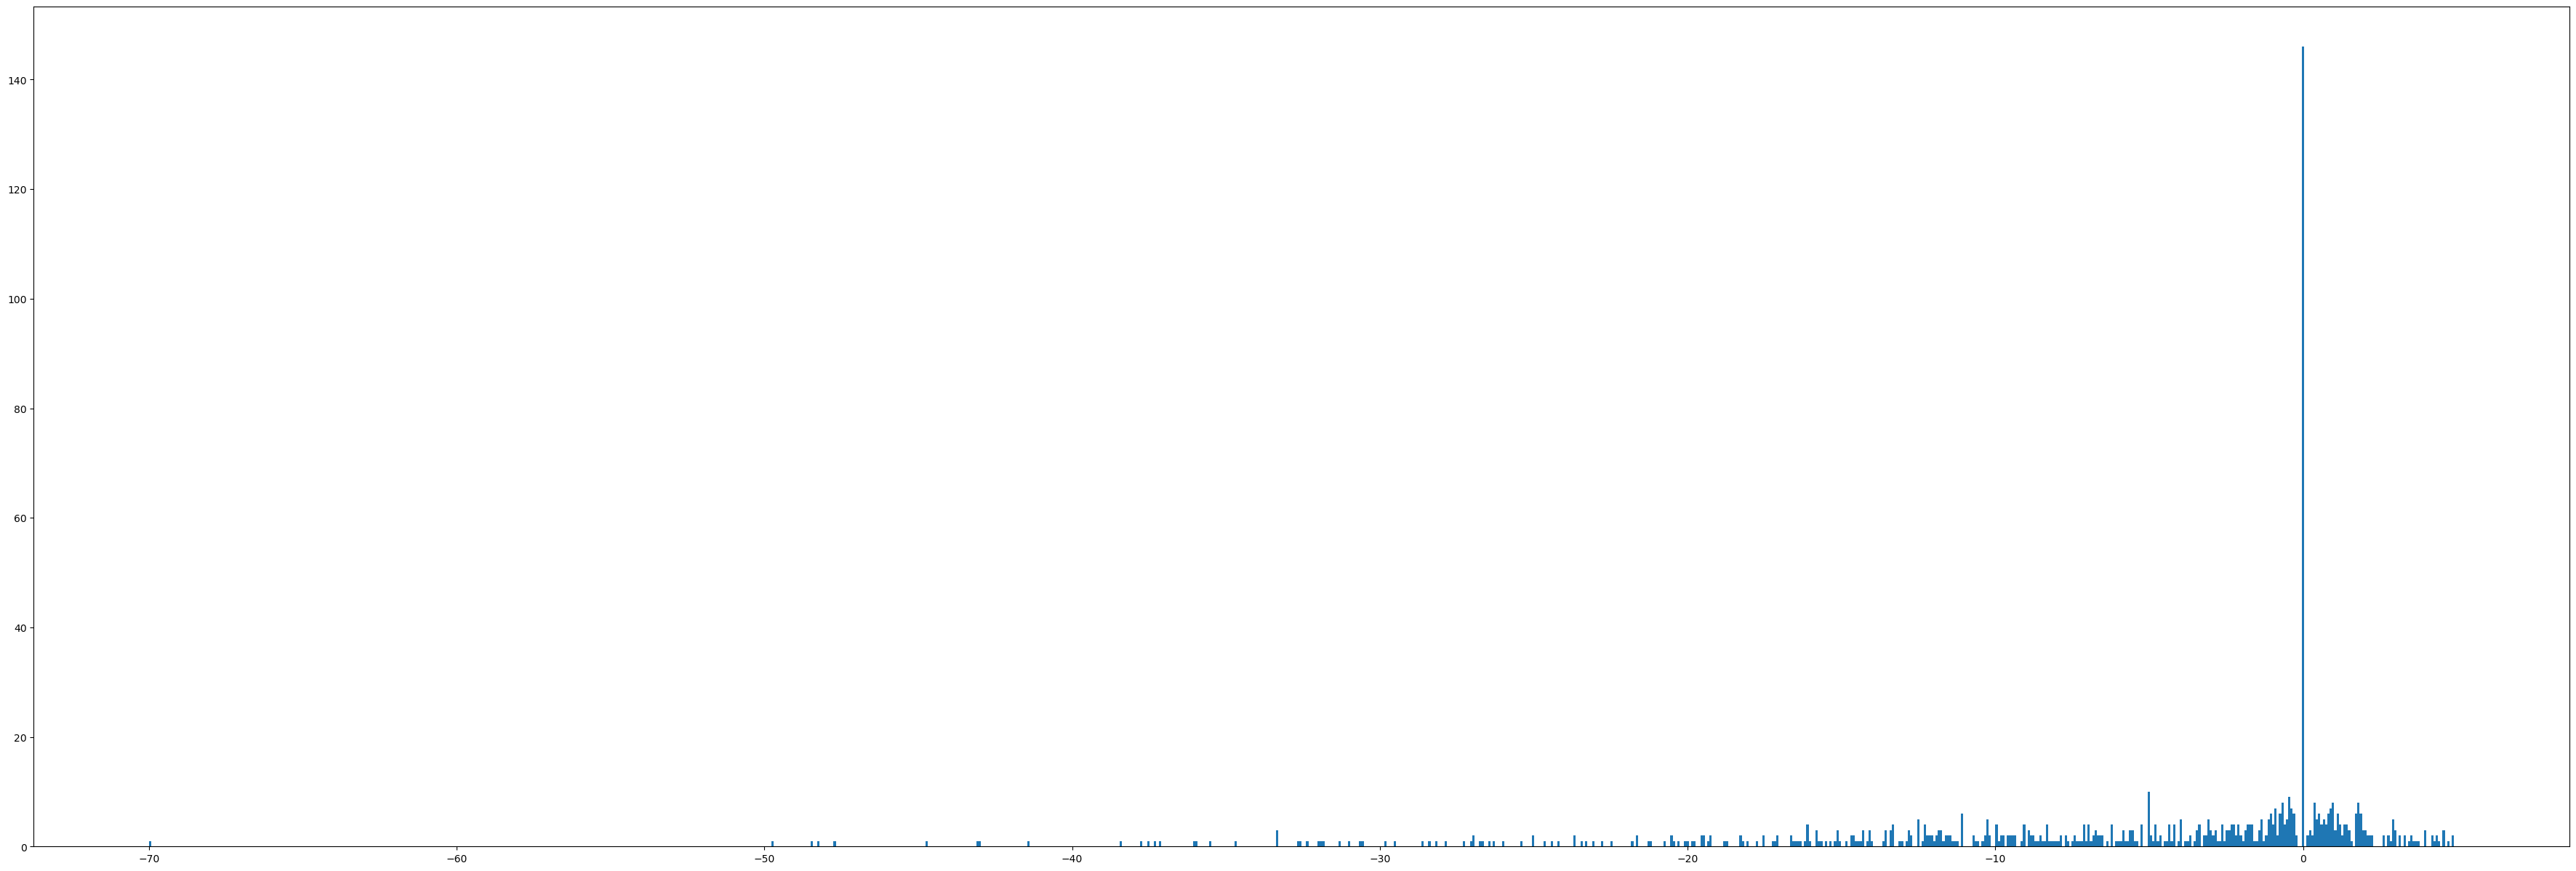

In [70]:
plt.figure(figsize=(45,15))
plt.hist(position_df[(position_df['return'] != np.inf) & (position_df['return'] != -np.inf)]['return'],bins=1000)
plt.show()

In [71]:
np.mean(position_df[(position_df['return'] != np.inf) & (position_df['return'] != -np.inf)]['return'])

-6.17873811311633

In [72]:
np.mean(position_df['days_in_trade'])

8.074441687344914

In [73]:
np.std(position_df[(position_df['return'] != np.inf) & (position_df['return'] != -np.inf)]['return'])

9.719549198646964

In [74]:
# position_df.to_csv(r'test_18_50_200.csv')

### Days in trade

In [75]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [76]:
# position_df = pd.read_csv(r'C:\Users\james\OneDrive\Documents\GitHub\jamsydLibrary\approved_projects\interactive_brokers\test_18_50_200.csv')

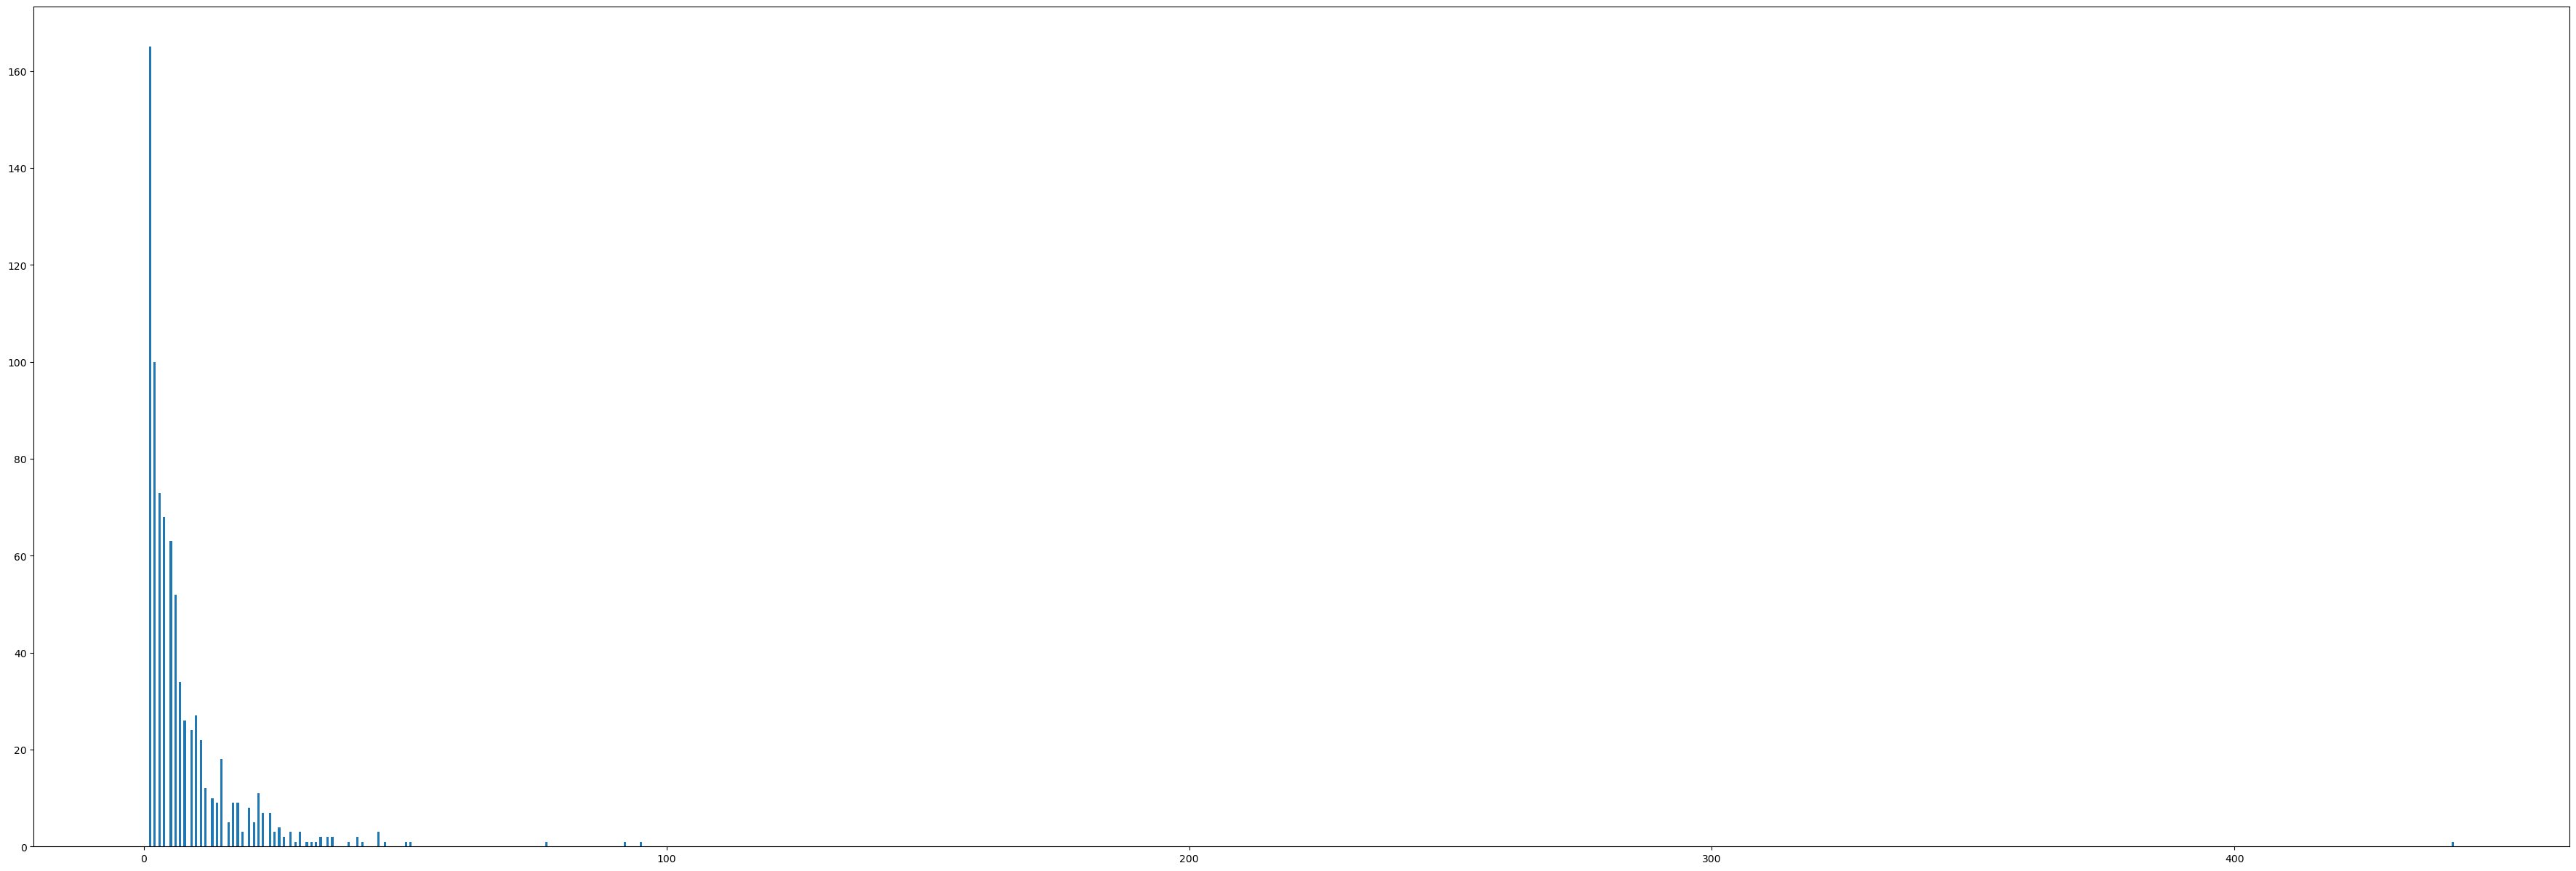

In [77]:
plt.figure(figsize=(45,15))
plt.hist(position_df['days_in_trade'],bins=1000)
plt.show()

### Historical trades

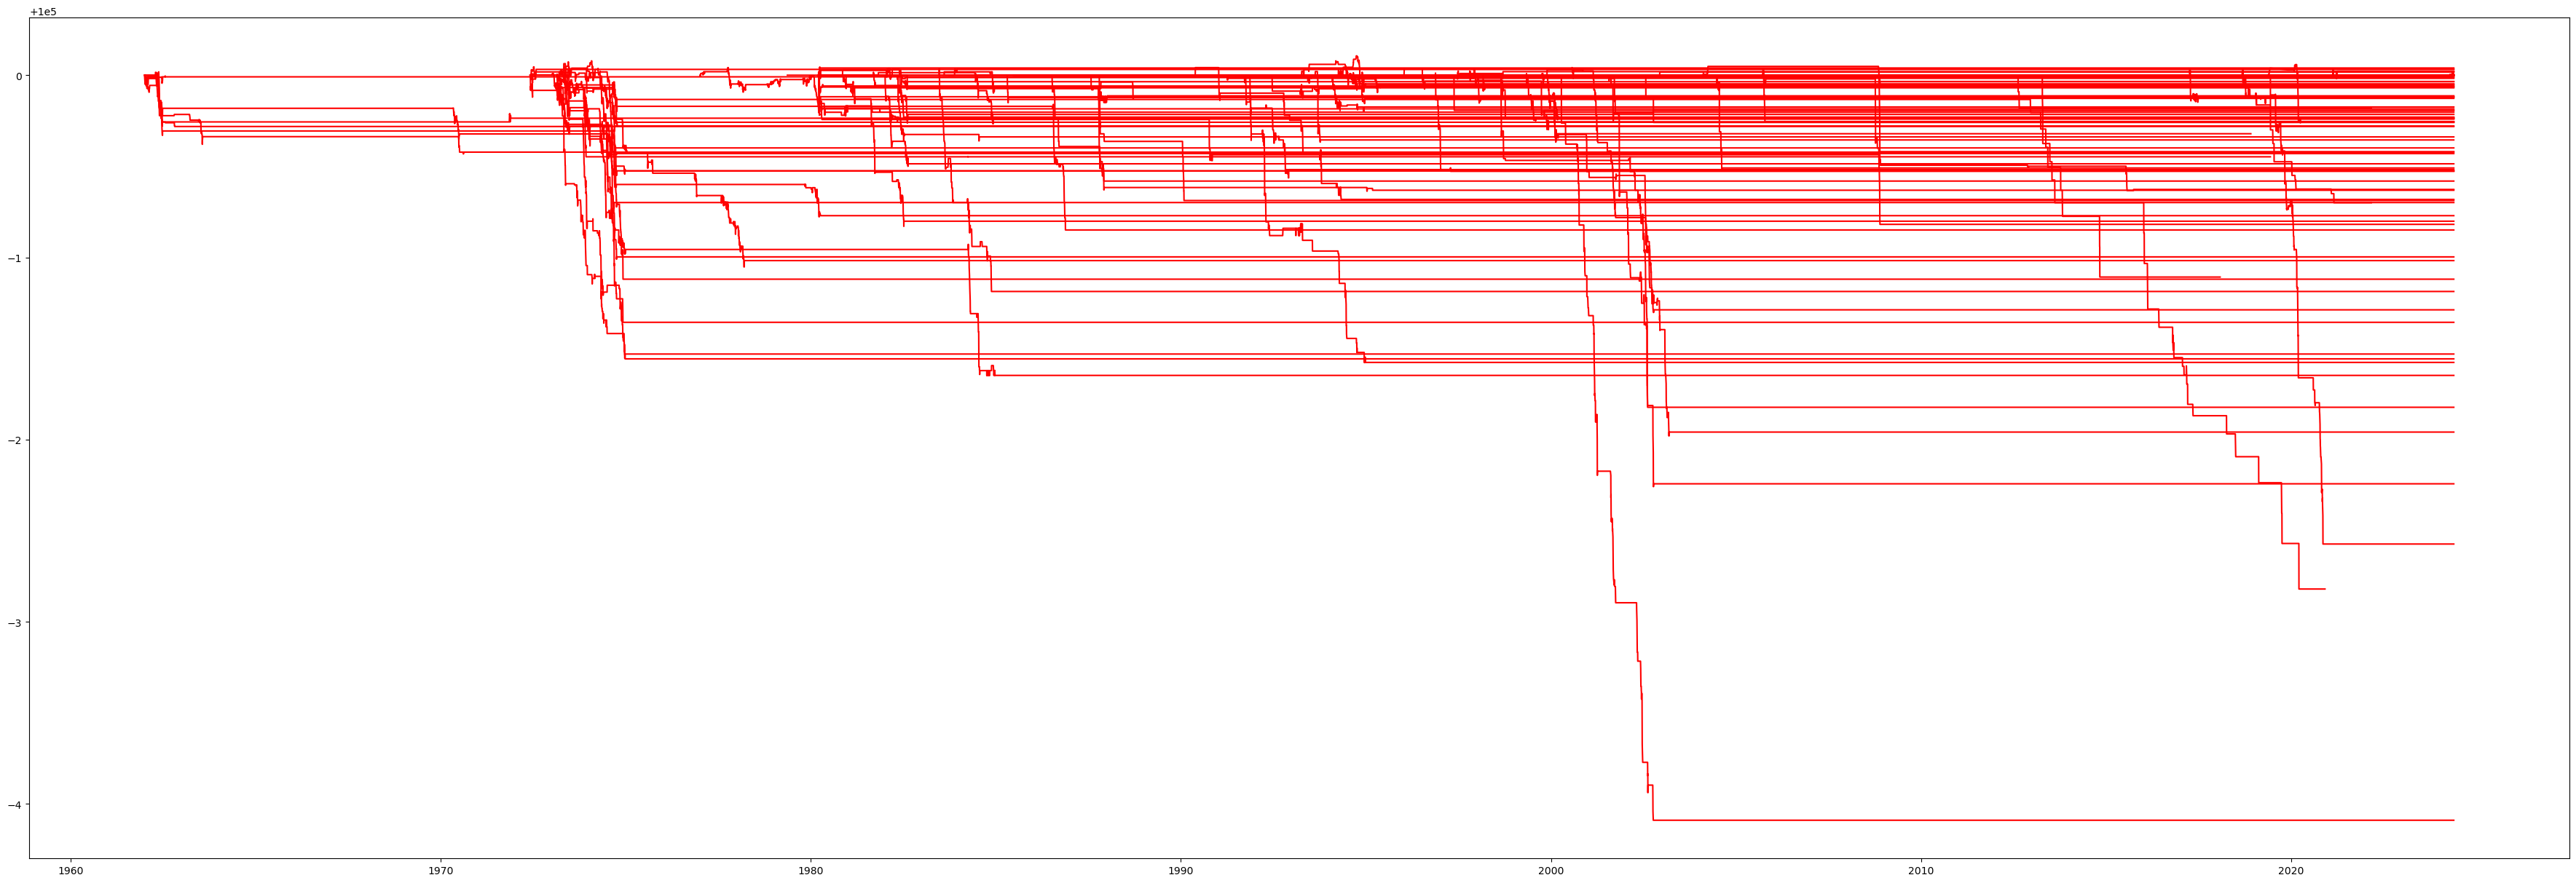

In [78]:
initial_capital = 100000
plt.figure(figsize=(45, 15))
for historical_time_series in historical_data:
    historical_time_series['pnl_vector'] = historical_time_series['pnl']*historical_time_series['position']*historical_time_series['position_size']
    plt.plot(initial_capital + historical_time_series['pnl_vector'].cumsum()/initial_capital,color='red')
plt.savefig('test.jpg')
plt.show()


In [79]:
historical_data[0].columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'ema', 'ema1', 'ema2', 'pnl', 'ath', 'ath_drawdown',
       'position', 'vector', 'position_size', 'entry_price', 'pnl_vector'],
      dtype='object')

In [80]:
historical_data[0]['vector'].unique()

array([0,
       'C:\\Users\\james\\OneDrive\\Documents\\GitHub\\jamsydLibrary\\approved_projects\\interactive_brokers\\Data\\spy_tickers\\AAPL_historical_data.csv_1',
       'C:\\Users\\james\\OneDrive\\Documents\\GitHub\\jamsydLibrary\\approved_projects\\interactive_brokers\\Data\\spy_tickers\\AAPL_historical_data.csv_47',
       'C:\\Users\\james\\OneDrive\\Documents\\GitHub\\jamsydLibrary\\approved_projects\\interactive_brokers\\Data\\spy_tickers\\AAPL_historical_data.csv_58',
       'C:\\Users\\james\\OneDrive\\Documents\\GitHub\\jamsydLibrary\\approved_projects\\interactive_brokers\\Data\\spy_tickers\\AAPL_historical_data.csv_170',
       'C:\\Users\\james\\OneDrive\\Documents\\GitHub\\jamsydLibrary\\approved_projects\\interactive_brokers\\Data\\spy_tickers\\AAPL_historical_data.csv_185',
       'C:\\Users\\james\\OneDrive\\Documents\\GitHub\\jamsydLibrary\\approved_projects\\interactive_brokers\\Data\\spy_tickers\\AAPL_historical_data.csv_188',
       'C:\\Users\\james\\OneDrive

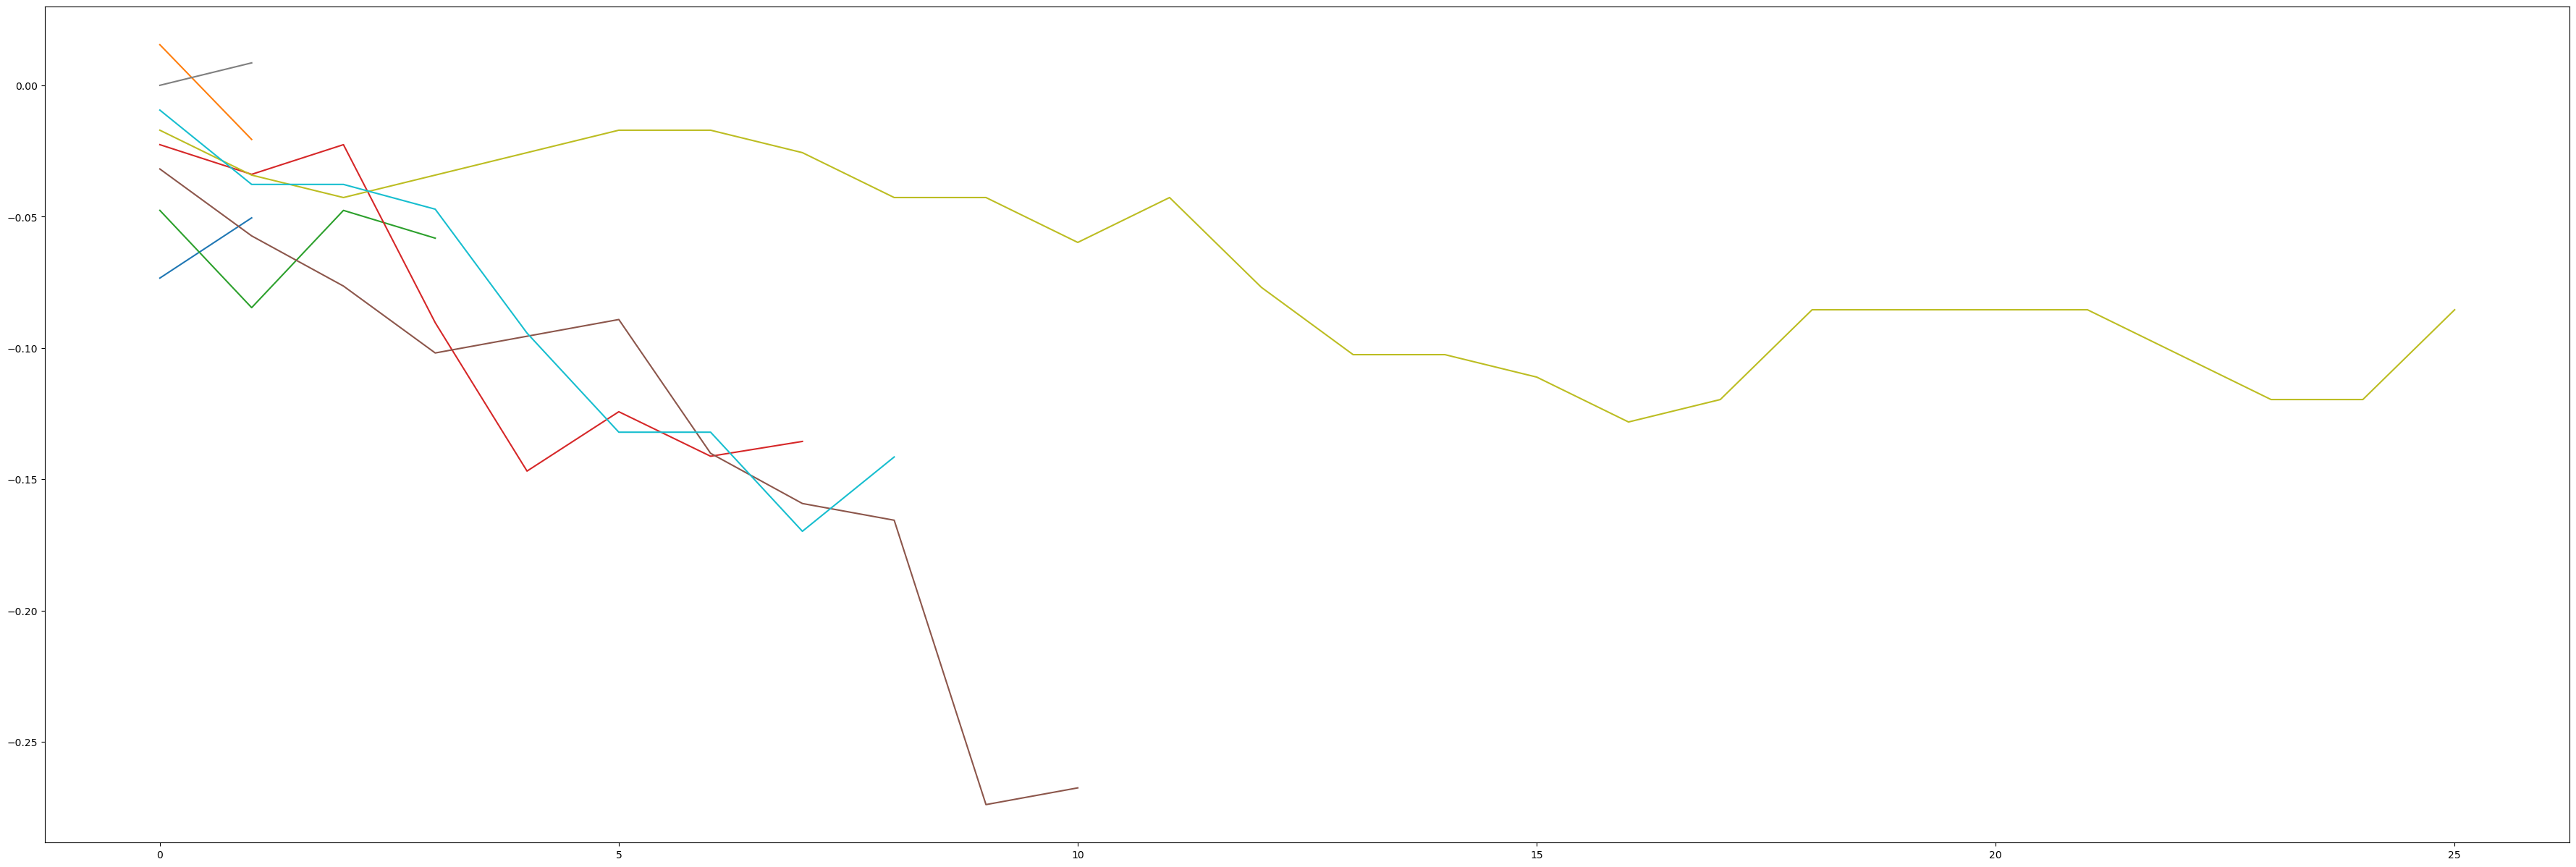

In [81]:
unique_vectors = historical_data[0]['vector'].unique()
plt.figure(figsize=(45,15))
for position in unique_vectors[1:]:
    pnl_vector = historical_data[0][historical_data[0]['vector'] == position]['pnl'].cumsum()/historical_data[0][historical_data[0]['vector'] == position]['entry_price']
    # pnl_vector = pnl_vector.reset_index()[0]
    
    plt.plot(pnl_vector.reset_index()[0])

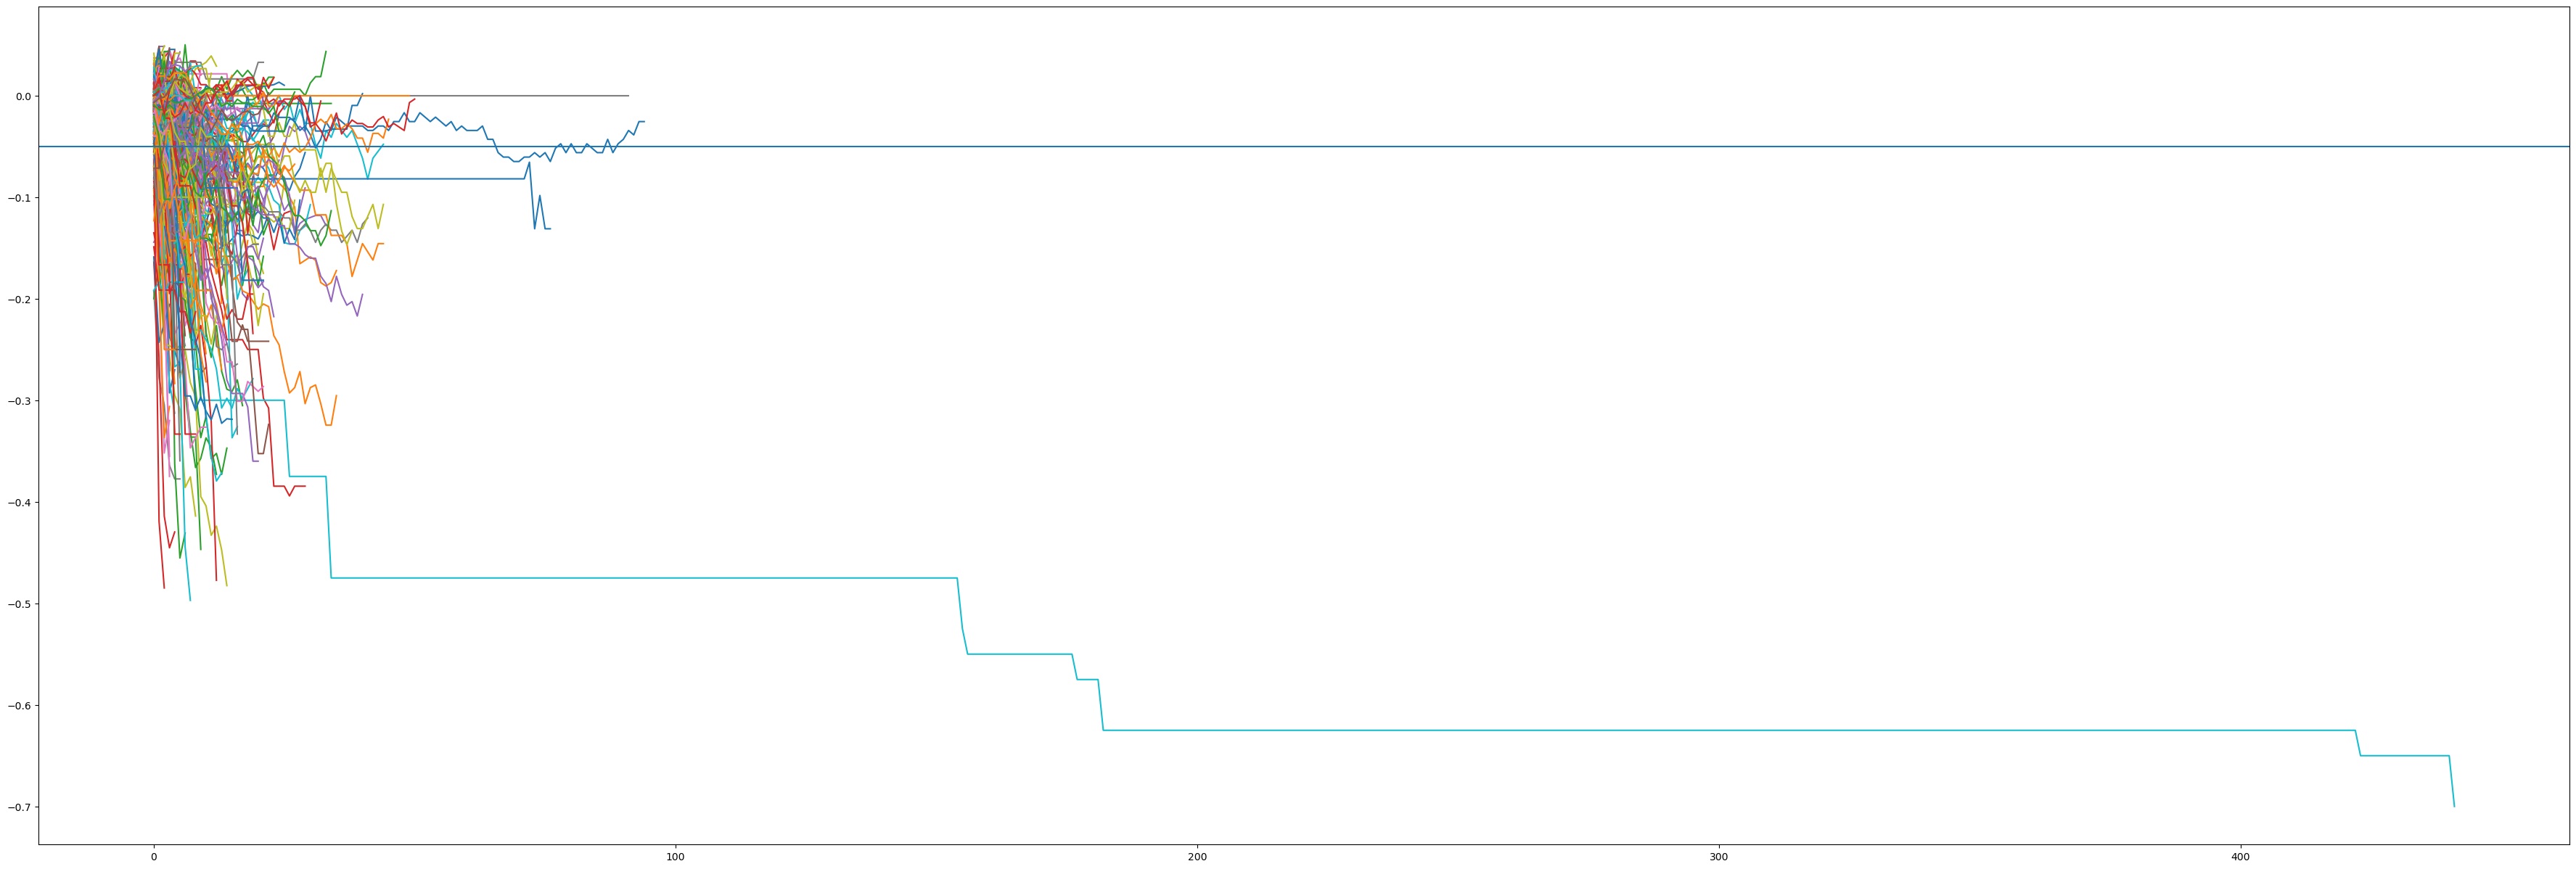

In [82]:
initial_capital = 100000
nine_day_pnl    = []
plt.figure(figsize=(45,15))
for historical_time_series in historical_data:
    historical_time_series['pnl_vector'] = historical_time_series['pnl']*historical_time_series['position']*historical_time_series['position_size']

    # Unique vectors
    unique_vectors = historical_time_series['vector'].unique()

    for position in unique_vectors[1:]:
        pnl_vector = historical_time_series[historical_time_series['vector'] == position]['pnl'].cumsum()/historical_time_series[historical_time_series['vector'] == position]['entry_price']

        plt.plot(pnl_vector.reset_index()[0])
        nine_day_pnl.append(pnl_vector.reset_index()[0].to_list())
plt.axhline(-0.05)
plt.show()


In [83]:
nine_day_pnl_df = pd.DataFrame(nine_day_pnl)

In [84]:
nine_day_pnl_df_mean    = nine_day_pnl_df.mean(axis=0)
nine_day_pnl_df_std     = nine_day_pnl_df.std(axis=0)
nine_day_pnl_df_median  = nine_day_pnl_df.median(axis=0)



In [85]:
nine_day_pnl_df

,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
0,-0.073398,-0.050464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.015463,-0.020617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.047626,-0.084661,-0.047626,-0.058207,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.022598,-0.033896,-0.022598,-0.090390,-0.146894,-0.124287,-0.141245,-0.135596,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0.000000,-0.027907,0.000000,-0.004651,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,-0.009259,-0.013889,-0.013889,-0.009259,-0.013889,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
803,0.000000,0.004695,-0.018780,0.004695,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,-0.005556,0.000000,0.013888,0.027777,0.030555,0.029167,0.023611,0.029167,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
import pandas as pd
import numpy as np
from scipy import stats

# Load your DataFrame
# nine_day_pnl_df = pd.read_csv('/mnt/data/your_dataframe.csv')  # Replace with the actual path to your DataFrame

confidence_level = 0.95
degrees_freedom = nine_day_pnl_df.shape[0] - 1
confidence_intervals = {}

for column in nine_day_pnl_df.columns:
    column_data = nine_day_pnl_df[column].dropna()
    if len(column_data) > 1:  # Ensure there is enough data to calculate statistics
        mean = column_data.mean()
        sem = stats.sem(column_data)  # Standard error of the mean
        confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean, scale=sem)
        confidence_intervals[column] = confidence_interval

# Convert the dictionary to a DataFrame for better visualization
confidence_intervals_df = pd.DataFrame(confidence_intervals, index=['Lower Bound', 'Upper Bound'])
print(confidence_intervals_df)


                   0         1         2         3         4         5   \
Lower Bound -0.017201 -0.029583 -0.043413 -0.052991 -0.060664 -0.067196   
Upper Bound -0.012683 -0.022646 -0.033182 -0.040898 -0.046841 -0.051445   

                   6         7         8         9   ...        85        86  \
Lower Bound -0.073510 -0.076725 -0.083047 -0.084914  ... -0.471203 -0.471203   
Upper Bound -0.055136 -0.056397 -0.061157 -0.061522  ...  0.117082  0.117082   

                   87        88        89        90        91        92  \
Lower Bound -0.470397 -0.471203 -0.470643 -0.470397 -0.469972 -0.685058   
Upper Bound  0.125014  0.117082  0.122347  0.125014  0.130415  0.171353   

                   93        94  
Lower Bound -0.691369 -0.691369  
Upper Bound  0.190774  0.190774  

[2 rows x 95 columns]


In [87]:
confidence_intervals_df.T['Lower Bound']

0    -0.017201
1    -0.029583
2    -0.043413
3    -0.052991
4    -0.060664
        ...   
90   -0.470397
91   -0.469972
92   -0.685058
93   -0.691369
94   -0.691369
Name: Lower Bound, Length: 95, dtype: float64

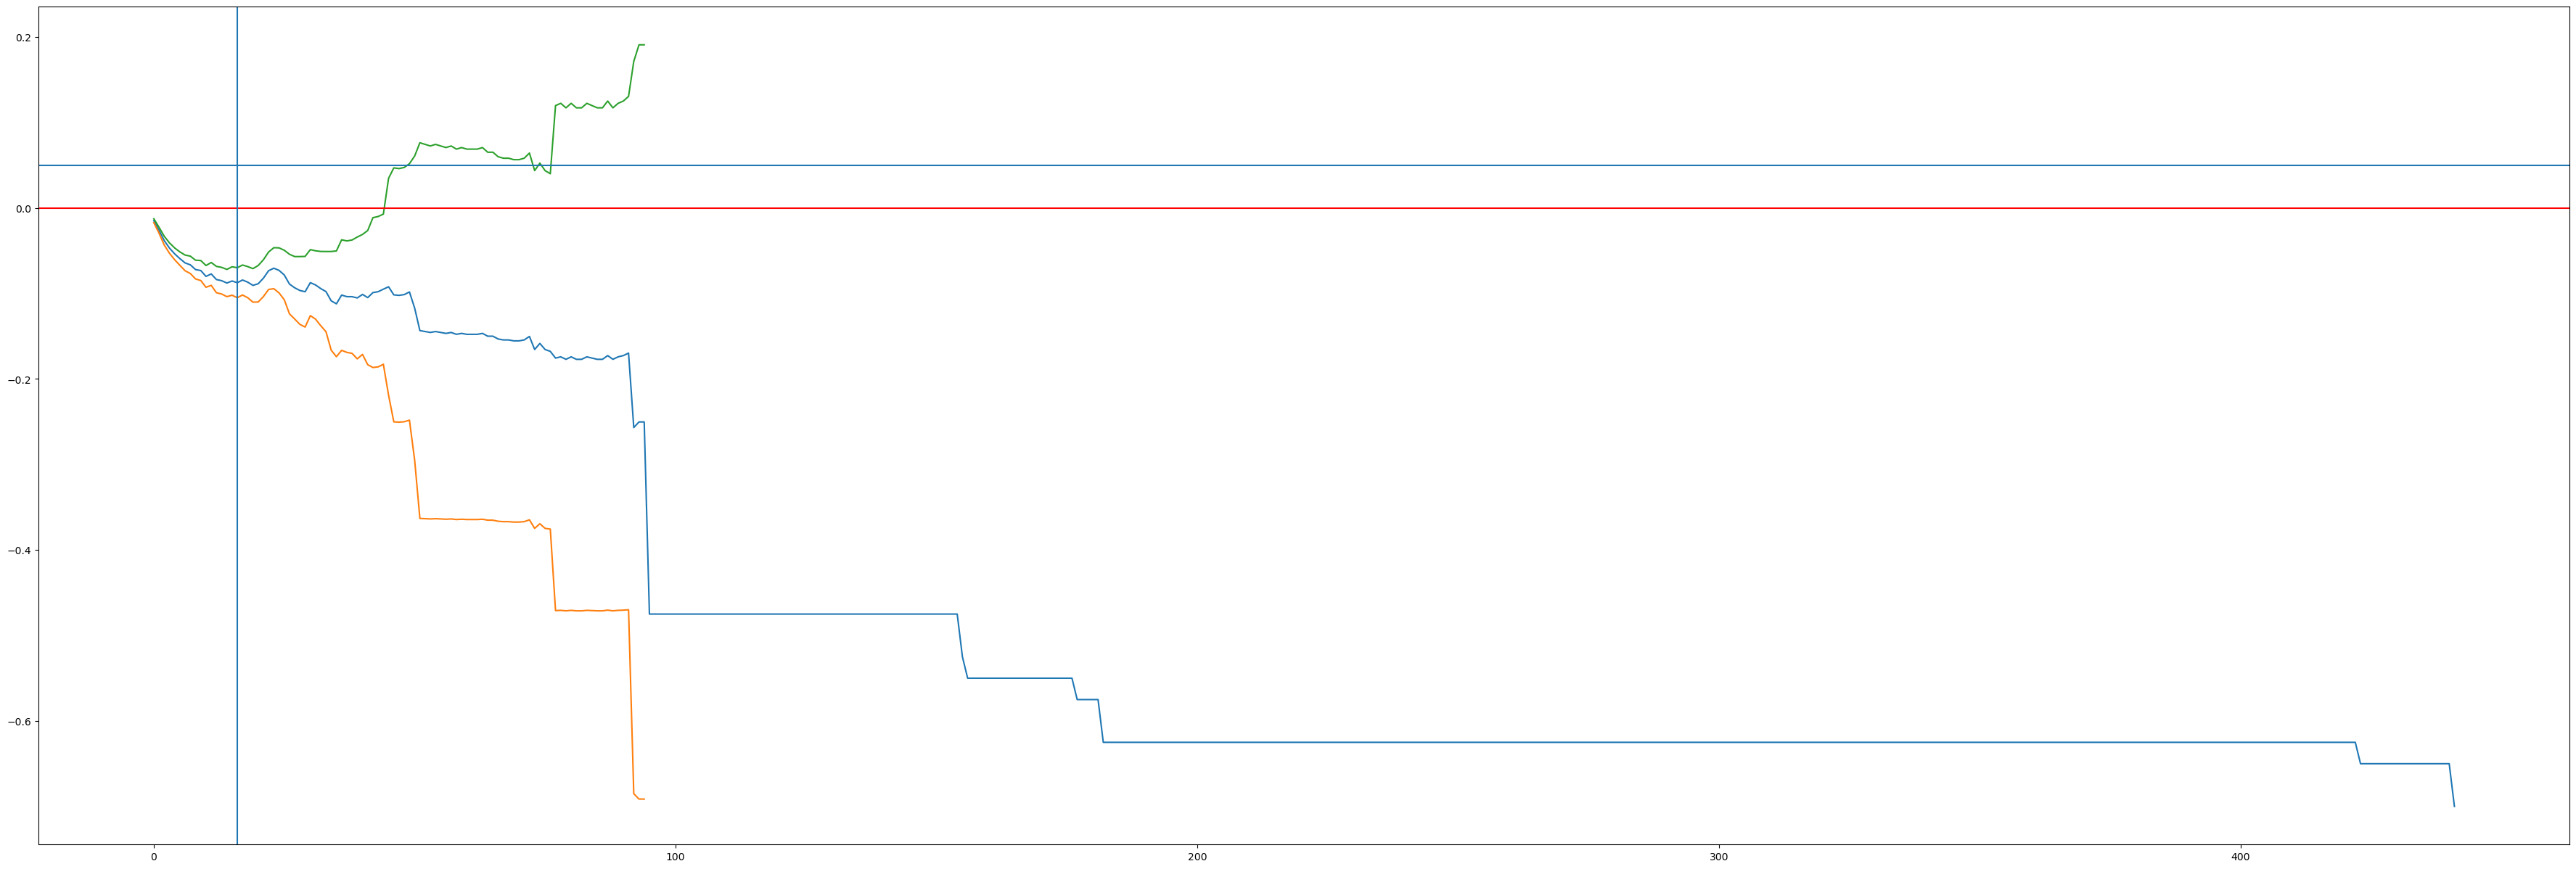

In [88]:
plt.figure(figsize=(45,15))
plt.plot(nine_day_pnl_df_mean)
plt.plot(confidence_intervals_df.T['Lower Bound'])
plt.plot(confidence_intervals_df.T['Upper Bound'])
# plt.plot(nine_day_pnl_df_median,color='pink')
plt.axhline(0,color='red')
plt.axhline(0.05)
plt.axvline(16)

plt.show()

In [89]:
nine_day_pnl_df_mean.to_csv('mean.csv')

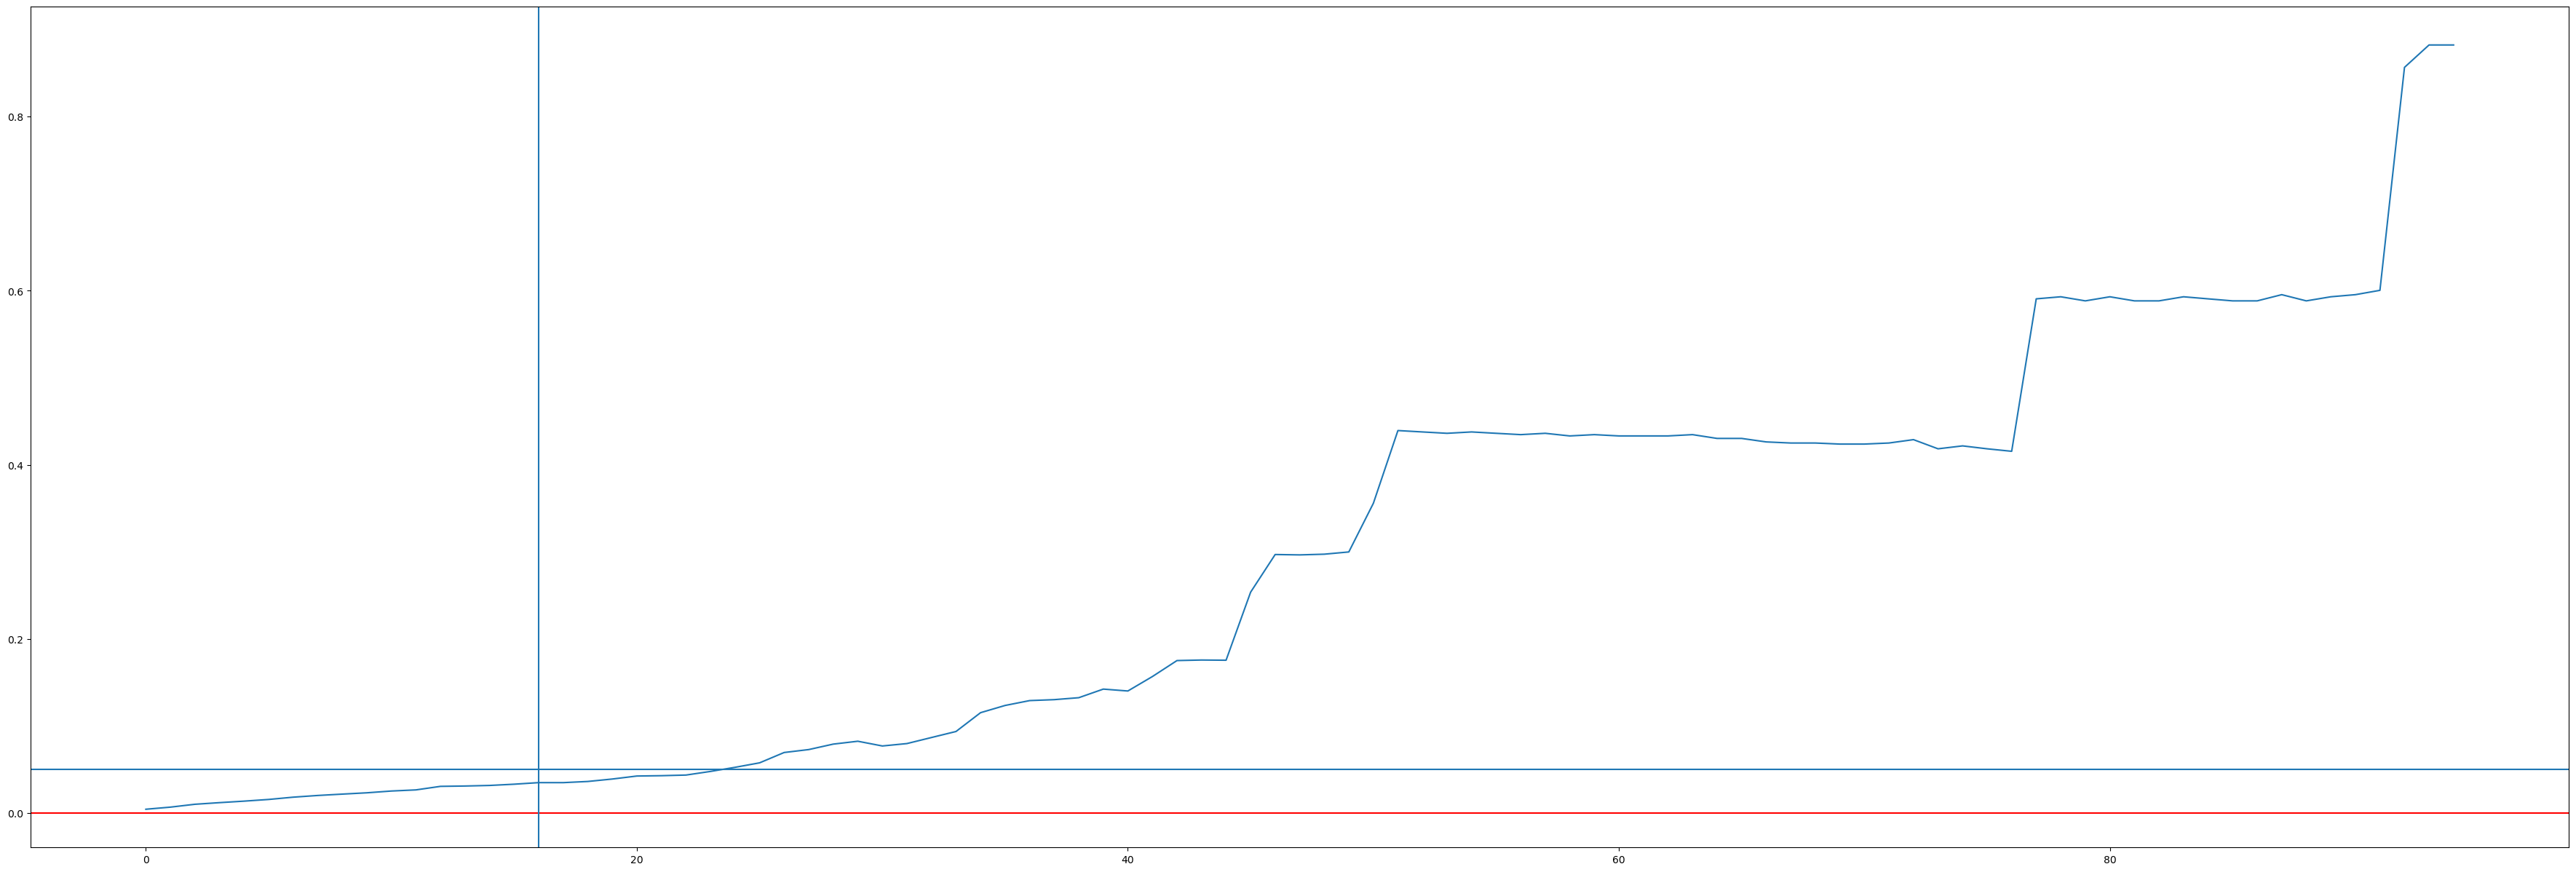

In [90]:
test = confidence_intervals_df.T.copy()
test['Spread'] = test['Upper Bound'] - test['Lower Bound']

plt.figure(figsize=(45,15))
plt.plot(test['Spread'])
plt.axhline(0,color='red')
plt.axhline(0.05)
plt.axvline(16)

plt.show()

In [91]:
len(nine_day_pnl)

806

In [92]:
initial_capital = 100000

for historical_time_series in historical_data:
    historical_time_series['pnl_vector'] = historical_time_series['pnl']*historical_time_series['position']*historical_time_series['position_size']
    for historical_time_series['']
    plt.plot(initial_capital + historical_time_series['pnl_vector'].cumsum()/initial_capital,color='red')
plt.savefig('test.jpg')
plt.show()


SyntaxError: invalid syntax (1026405941.py, line 5)

In [ ]:
initial_capital = 100000
historical_returns_profile = []
for historical_time_series in historical_data:
    historical_time_series['pnl_vector'] = historical_time_series['pnl']*historical_time_series['position']*historical_time_series['position_size']
    returns = initial_capital + historical_time_series['pnl_vector'].cumsum()
    historical_returns_profile.append((returns.iloc[-1])/initial_capital)


In [ ]:
print(historical_returns_profile)

[8.977514941302463, 4.88359933474183, 7.52388582877934, 1.0, 4.690965539369584, 9.813138112211378, 7.033141482815742, 6.154490794314146, 7.506415056620834, 8.42395537776828, 2.97067251373291, 5.540786621677878, 3.9015446854233726, 4.476216368799208, 8.679878089123331, 5.711784148073196, 4.4448214317697285, 3.436858236846925, 1.605026875, 4.255032692489624, 2.7670458955955506, 9.744559506409614, 5.443883171815872, 9.085112165923416, 4.240120929546355, 3.861740236434936]


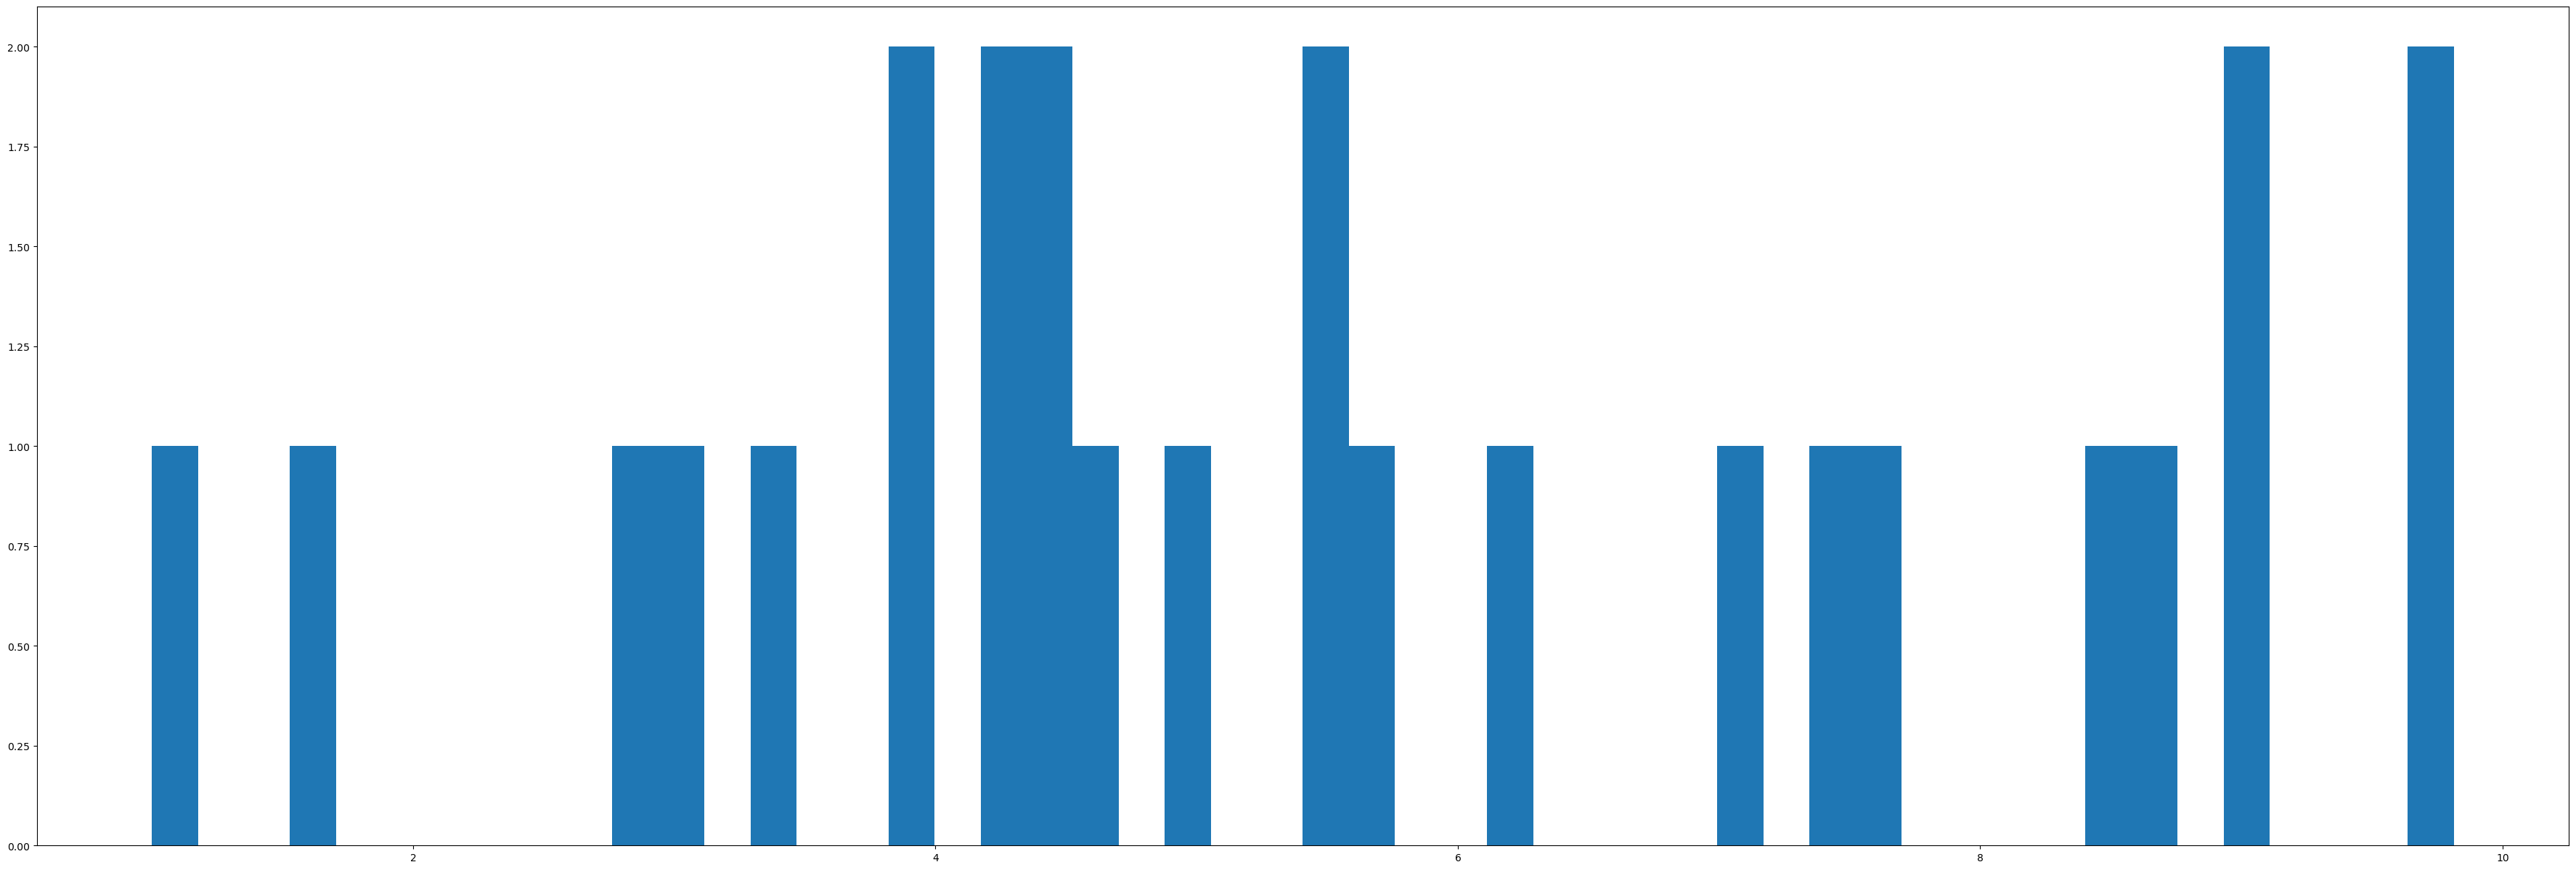

In [ ]:
plt.figure(figsize=(45,15))
plt.hist(historical_returns_profile,bins=50)
plt.show()

# Drawdown Analytics

In [ ]:
def rolling_max_drawdown(series, window=252):
    """
    Calculate the rolling maximum drawdown for a given series and window.
    """
    roll_max = series.rolling(window, min_periods=1).max()
    drawdown = series / roll_max - 1.0
    max_drawdown = drawdown.rolling(window, min_periods=1).min()

    return max_drawdown


In [ ]:
# Assuming your DataFrame is named time_series and has the column 'close'
time_series['rolling_max_drawdown'] = rolling_max_drawdown(initial_capital + time_series['pnl_vector'].cumsum(), window=252)

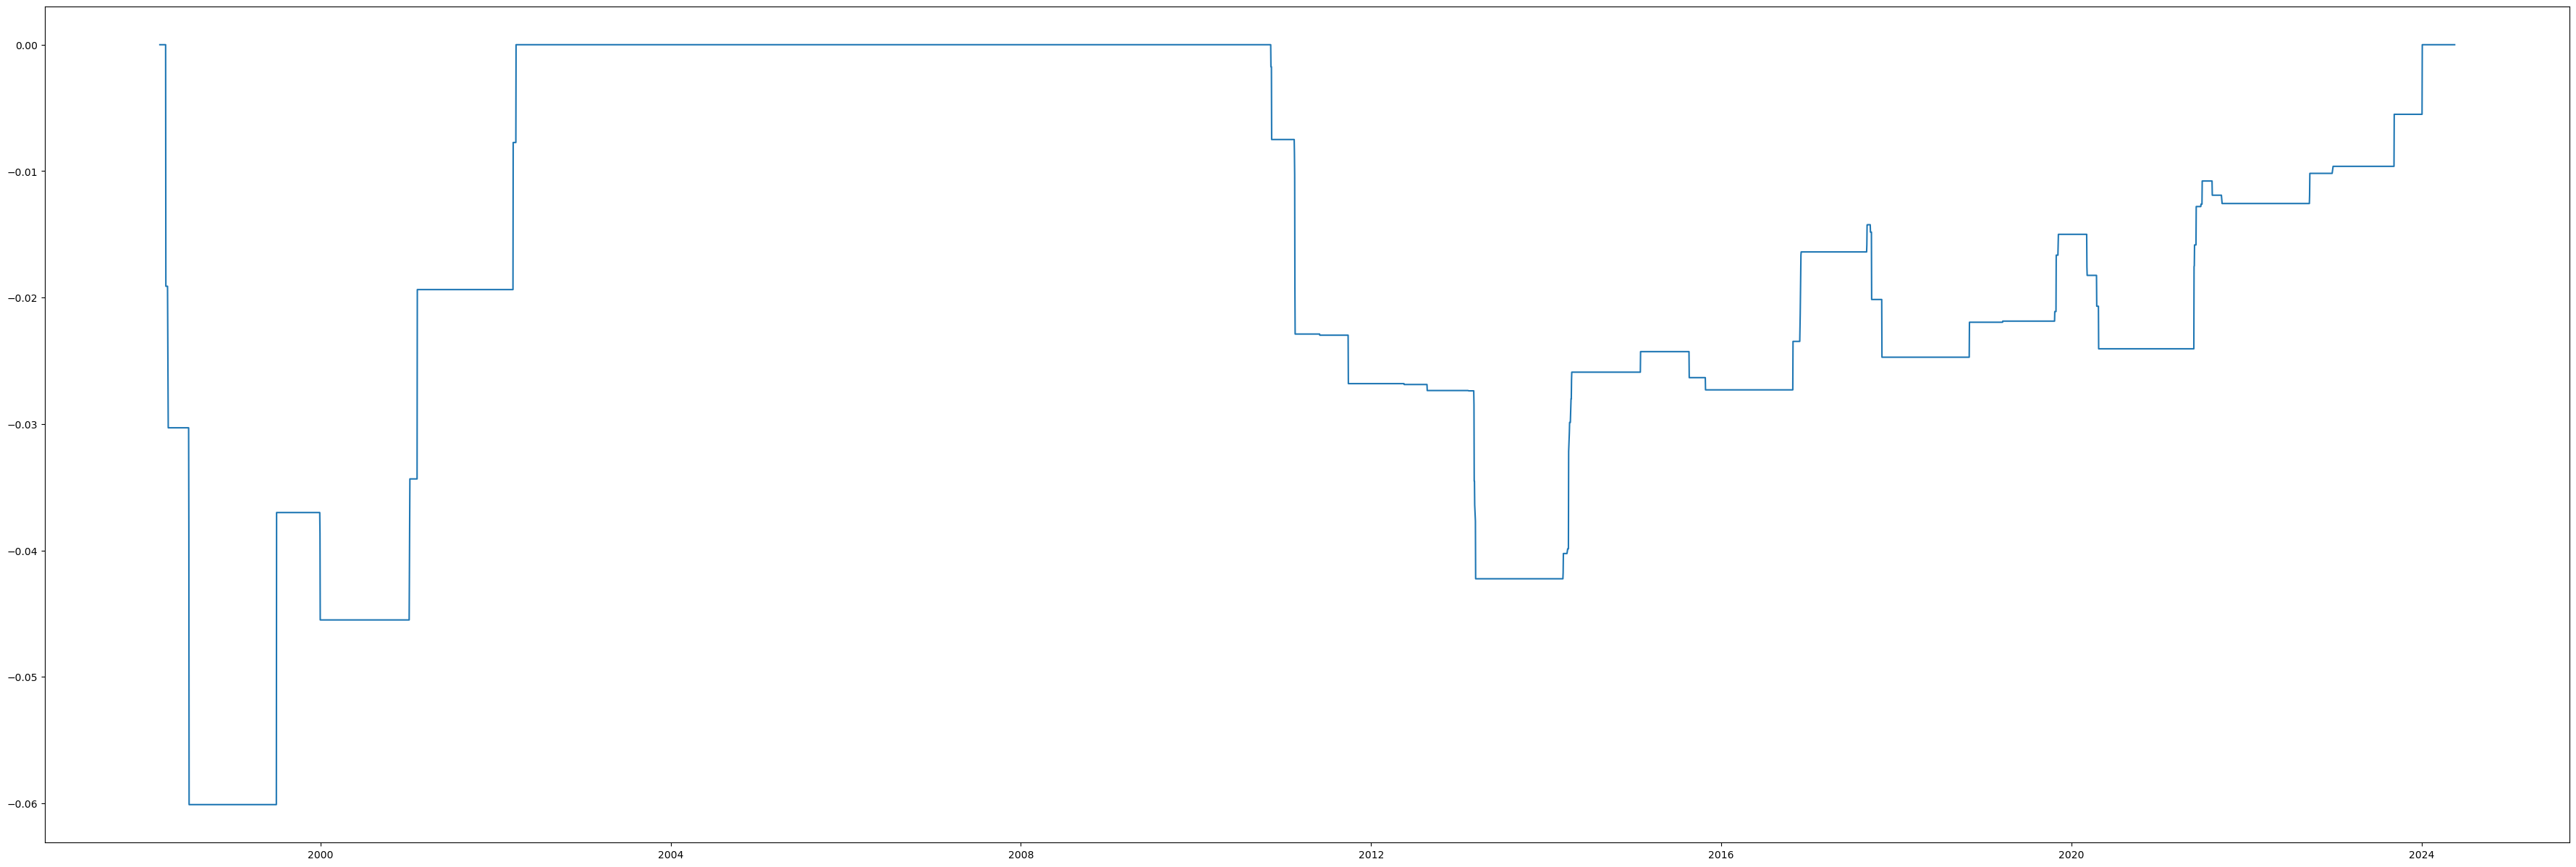

In [ ]:
plt.figure(figsize=(45, 15))
plt.plot(time_series['rolling_max_drawdown'])
plt.show()

# Sharpe Analytics

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Load your trading strategy returns
# Replace 'your_returns.csv' with the actual file containing your returns data
# The returns should be in a column named 'returns'
# data = pd.read_csv('your_returns.csv')

returns = time_series[time_series['pnl_vector'] !=0]['pnl_vector']

# Calculate the Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0.05):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

# Calculate the Maximum Drawdown
def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Calculate Skewness
def skewness(returns):
    return stats.skew(returns)

# Calculate Kurtosis
def kurtosis(returns):
    return stats.kurtosis(returns)

# Calculate Left Tail Fatness (probability of extreme negative returns)
def left_tail_fatness(returns, threshold=-0.05):
    return np.sum(returns < threshold) / len(returns)

# Calculate Right Tail Fatness (probability of extreme positive returns)
def right_tail_fatness(returns, threshold=0.05):
    return np.sum(returns > threshold) / len(returns)

# Calculate metrics
sharpe = sharpe_ratio(returns)
max_dd = max_drawdown(returns)
skew = skewness(returns)
kurt = kurtosis(returns)
left_tail = left_tail_fatness(returns)
right_tail = right_tail_fatness(returns)

# Print metrics
print(f'Sharpe Ratio: {sharpe:.2f}')
print(f'Maximum Drawdown: {max_dd:.2%}')
print(f'Skewness: {skew:.2f}')
print(f'Kurtosis: {kurt:.2f}')
print(f'Left Tail Fatness (returns < -5%): {left_tail:.2%}')
print(f'Right Tail Fatness (returns > 5%): {right_tail:.2%}')


Sharpe Ratio: 0.14
Maximum Drawdown: -258034391152523378688.00%
Skewness: nan
Kurtosis: nan
Left Tail Fatness (returns < -5%): 43.80%
Right Tail Fatness (returns > 5%): 56.13%


c:\Users\james\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


In [ ]:
# # Probability of success
# # Import necessary libraries
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# from sklearn import tree

# # Load your dataset
# # For example, using a CSV file
# # Replace 'your_dataset.csv' with your actual dataset file
# data = pd.read_csv('your_dataset.csv')

# # Assume the target variable is named 'target'
# # and all other columns are features
# X = data.drop('target', axis=1)
# y = data['target']

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the Decision Tree Classifier
# clf = DecisionTreeClassifier(random_state=42)

# # Train the classifier
# clf.fit(X_train, y_train)

# # Predict on the test set
# y_pred = clf.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')
# print('Classification Report:')
# print(classification_report(y_test, y_pred))
# print('Confusion Matrix:')
# print(confusion_matrix(y_test, y_pred))

# # Plot the decision tree
# plt.figure(figsize=(20,10))
# tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names
